In [2]:
# Get the data from Kaggle:
# !kaggle datasets download -d vishalsubbiah/pokemon-images-and-types

!mkdir -p ../input/pokemon-images-and-types
!unzip pokemon-images-and-types.zip -d ../input/pokemon-images-and-types

/usr/bin/sh: 1: kaggle: not found
Archive:  pokemon-images-and-types.zip
  inflating: ../input/pokemon-images-and-types/images/images/abomasnow.png  
  inflating: ../input/pokemon-images-and-types/images/images/abra.png  
  inflating: ../input/pokemon-images-and-types/images/images/absol.png  
  inflating: ../input/pokemon-images-and-types/images/images/accelgor.png  
  inflating: ../input/pokemon-images-and-types/images/images/aegislash-blade.png  
  inflating: ../input/pokemon-images-and-types/images/images/aerodactyl.png  
  inflating: ../input/pokemon-images-and-types/images/images/aggron.png  
  inflating: ../input/pokemon-images-and-types/images/images/aipom.png  
  inflating: ../input/pokemon-images-and-types/images/images/alakazam.png  
  inflating: ../input/pokemon-images-and-types/images/images/alomomola.png  
  inflating: ../input/pokemon-images-and-types/images/images/altaria.png  
  inflating: ../input/pokemon-images-and-types/images/images/amaura.png  
  inflating: ../inp

  inflating: ../input/pokemon-images-and-types/images/images/palpitoad.png  
  inflating: ../input/pokemon-images-and-types/images/images/pancham.png  
  inflating: ../input/pokemon-images-and-types/images/images/pangoro.png  
  inflating: ../input/pokemon-images-and-types/images/images/panpour.png  
  inflating: ../input/pokemon-images-and-types/images/images/pansage.png  
  inflating: ../input/pokemon-images-and-types/images/images/pansear.png  
  inflating: ../input/pokemon-images-and-types/images/images/paras.png  
  inflating: ../input/pokemon-images-and-types/images/images/parasect.png  
  inflating: ../input/pokemon-images-and-types/images/images/passimian.jpg  
  inflating: ../input/pokemon-images-and-types/images/images/patrat.png  
  inflating: ../input/pokemon-images-and-types/images/images/pawniard.png  
  inflating: ../input/pokemon-images-and-types/images/images/pelipper.png  
  inflating: ../input/pokemon-images-and-types/images/images/persian.png  
  inflating: ../input

In [5]:
!pip3 install pandas numpy matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 31.2 MB 3.7 MB/s eta 0:00:011
     |████████████████████████████████| 33.8 MB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 10.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Explore the data

Read the images and metadata information, and display examples of images.

In [6]:
import os
import pandas as pd

INPUT_DIR = '../input/pokemon-images-and-types'

pokemon = pd.read_csv(os.path.join(INPUT_DIR, 'pokemon.csv'))
pokemon = pokemon.sort_values(by='Name')

display(pokemon.head())
display(pokemon.describe())
display(pokemon['Type1'].unique())

,Name,Type1,Type2
459,abomasnow,Grass,Ice
62,abra,Psychic,NaN
358,absol,Dark,NaN
616,accelgor,Bug,NaN
680,aegislash-blade,Steel,Ghost


,Name,Type1,Type2
count,809,809,405
unique,809,18,18
top,abomasnow,Water,Flying
freq,1,114,95


array(['Grass', 'Psychic', 'Dark', 'Bug', 'Steel', 'Rock', 'Normal',
       'Water', 'Dragon', 'Electric', 'Poison', 'Fire', 'Fairy', 'Ice',
       'Ground', 'Ghost', 'Fighting', 'Flying'], dtype=object)

In [7]:
from PIL import Image
import numpy as np
from tensorflow.keras.utils import img_to_array


def read_img(imgname):
    img = Image.open(imgname)
    img = img.convert('RGBA')
    
    basename = os.path.basename(imgname)
    name, suffix = basename.split('.') 

    # unify the PNG and JPG files by adding a white background to PNG files
    # and drop the alpha channel
    if suffix == 'png':
        white_bg = Image.new('RGBA', img.size, (255, 255, 255))
        img = Image.alpha_composite(white_bg, img)
    
    mdata = img_to_array(img, dtype='float32')
    mdata = 1.0 - mdata.astype(np.float32) / 255

    return mdata[:, :, :3], name

# Preprocessing Data

Create data preprocessing functions that reads in the following data:

- Label data with "Type1" of pokemon metadata, with OneHotEncoding.
- The image data from JPG and PNG files in the images/images directory.

The output data uses a generator to return `(image_data, label)` tuples, and creates `tf.data.Dataset`.

In [8]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

type1 = encoder.fit_transform(pokemon['Type1'].values)
display(type1)
encoder.classes_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

array(['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
       'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
       'Psychic', 'Rock', 'Steel', 'Water'], dtype='<U8')

In [9]:
# create encoder/decoder for type1 labels

def get_type1name(name):
    return pokemon[pokemon['Name'] == name]['Type1'].values[0]

def encode_type(type_name):
    return encoder.transform(type_name)

def decode_type(type1):
    return encoder.inverse_transform(type1)

In [10]:
# test out the label encoder:

print('Type1 of pokemon abomasnow:', get_type1name('abomasnow'))

typelabel1 = encode_type(['Grass'])
print('Type1 encoding of Grass:', typelabel1)

print('Reverse decode of type:', decode_type(typelabel1))


Type1 of pokemon abomasnow: Grass
Type1 encoding of Grass: [[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
Reverse decode of type: ['Grass']


In [11]:
# Create generator for result image data

import os

def gen_train_imgs():
    imglist = os.listdir(os.path.join(INPUT_DIR, 'images/images'))
    
    for i, img in enumerate(imglist):        
        imgdata, name = read_img(os.path.join(INPUT_DIR, 'images/images', img))
        pokemon_type = get_type1name(name)
        
        type_label = encode_type([pokemon_type])[0]
        yield (imgdata, type_label)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-byf326c9 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


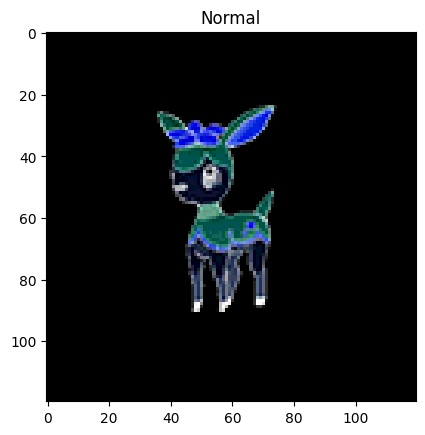

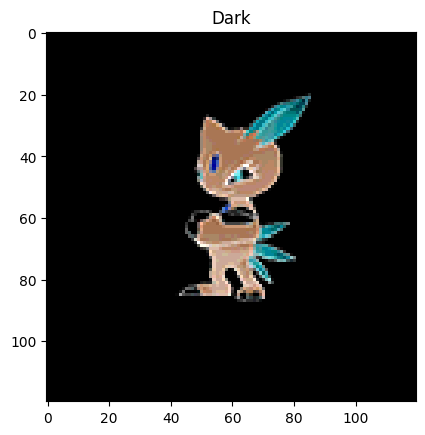

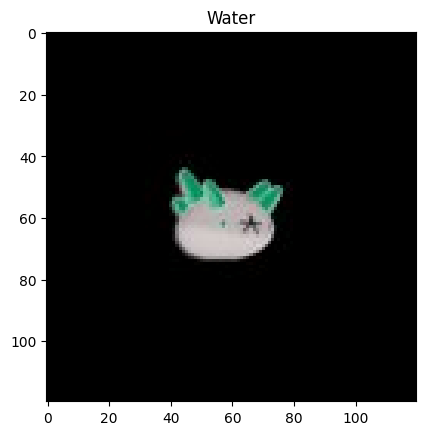

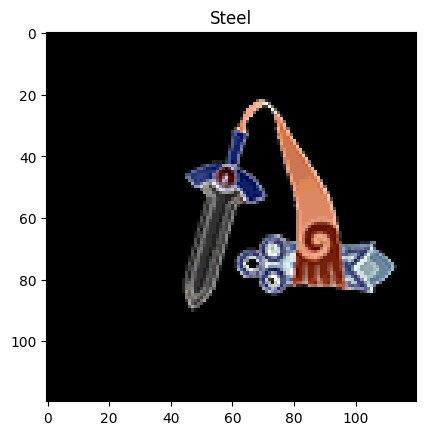

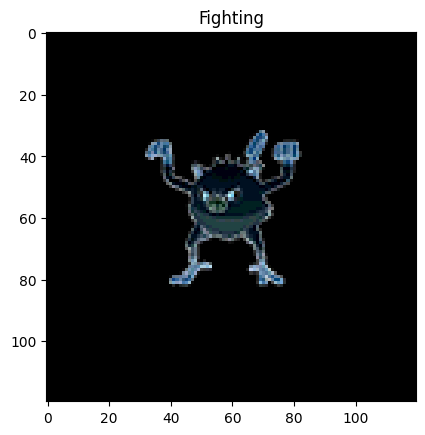

In [12]:
# Test the generator and show the images
# The images are preprocessed and scaled to (-1,1) so it would look weird on the display

import matplotlib.pyplot as plt

g = gen_train_imgs()

for i in range(5):
    mdata, label = next(g)
    
    labelname = decode_type(np.array([label]))
    plt.title(labelname[0])
    plt.imshow(mdata)
    plt.show()

In [13]:
import tensorflow as tf

dataset = tf.data.Dataset.from_generator(
    gen_train_imgs,
    output_signature=(
        tf.TensorSpec(shape=(120,120,3), dtype=tf.float32),
        tf.TensorSpec(shape=(18,), dtype=tf.int32),
    ),
)

In [14]:
# split the train validation
data_size = pokemon.shape[0]

train_size = int(data_size * 0.8)
val_size = data_size - train_size

print(f'Splitting data size of {data_size} to train: {train_size} and val: {val_size}')
dataset = dataset.shuffle(32)

train_data = dataset.take(train_size).batch(8)
val_data = dataset.skip(train_size).take(val_size).batch(8)

Splitting data size of 809 to train: 647 and val: 162


# Create Tensorflow Model

Create CNN model with Tensorflow Keras library, with Convolutional, Maxpooling layers, and output the result vector the shape of (# of classes).

In [15]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras import regularizers

from tensorflow.keras.optimizers import Adam

def build_model():
    model = tf.keras.Sequential([
        Conv2D(32, 3, 3, input_shape=(120, 120, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        Conv2D(16, 3, 3, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(18, activation='softmax'),
    ])
    model.compile(optimizer=Adam(lr=0.005),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 16)          0

In [16]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
)

Epoch 1/20
81/81 [==============================] - 21s 59ms/step - loss: 2.8542 - accuracy: 0.1097 - val_loss: 2.8265 - val_accuracy: 0.0988
Epoch 2/20
81/81 [==============================] - 2s 30ms/step - loss: 2.7894 - accuracy: 0.1345 - val_loss: 2.7591 - val_accuracy: 0.0926
Epoch 3/20
81/81 [==============================] - 2s 30ms/step - loss: 2.7638 - accuracy: 0.1159 - val_loss: 2.7017 - val_accuracy: 0.0988
Epoch 4/20
81/81 [==============================] - 2s 30ms/step - loss: 2.7367 - accuracy: 0.1113 - val_loss: 2.6790 - val_accuracy: 0.1358
Epoch 5/20
81/81 [==============================] - 2s 30ms/step - loss: 2.6981 - accuracy: 0.1638 - val_loss: 2.5684 - val_accuracy: 0.2407
Epoch 6/20
81/81 [==============================] - 2s 30ms/step - loss: 2.6880 - accuracy: 0.1484 - val_loss: 2.5508 - val_accuracy: 0.2346
Epoch 7/20
81/81 [==============================] - 2s 30ms/step - loss: 2.6175 - accuracy: 0.1947 - val_loss: 2.4673 - val_accuracy: 0.2840
Epoch 8/20
8

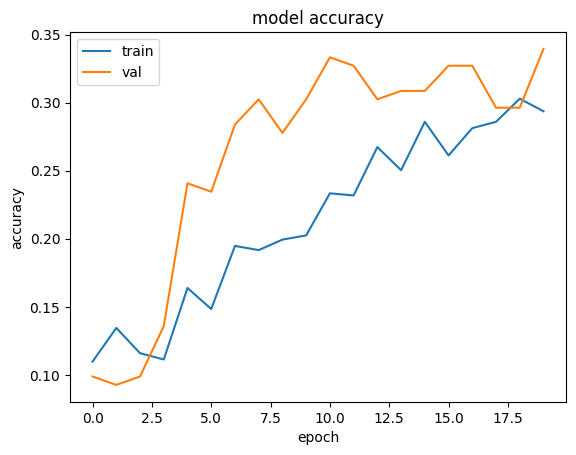

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

There are still many possible ways to potentially improve the model accuracy by:

- Update to popular CNN network architectures with deeper layers.
- Preprocess and transform the images to prevent overfitting.
- Hyperparameter tuning.
- More..